# Stock Price Predictor but playing with different parameters

In [12]:
# Import dependencies

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, GRU, Dense
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from matplotlib.ticker import MultipleLocator
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' #This line is necessary on macbook s.t. models compile
import os
from talib import RSI, BBANDS, MACD

plt.style.use('seaborn-colorblind')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [193]:
def clean_data():
    # Import and concatenate data
    df1 = pd.read_csv('Good Data/S&P 500 Historical Data (1).csv')
    df2 = pd.read_csv('Good Data/S&P 500 Historical Data (2).csv')
    df3 = pd.read_csv('Good Data/S&P 500 Historical Data (3).csv')
    df = pd.concat([df3, df2, df1], axis = 0, join = 'outer')
    
    # Set Date column to datetime format, and set as index
    df['Date'] = pd.to_datetime(df['Date'], format = '%d/%m/%Y', errors = 'coerce')
    df = df.set_index('Date')
    
    # Clean data and rename remaining columns to make typing easier
    df = df.drop(df[df["Price"]==0].index)
    df = df.drop(['High', 'Low', 'Vol.', 'Change %'], axis = 1)
    df = df.rename(columns={'Price': 'close'})
    df = df.rename(columns={'Open': 'open'})
    df = df.dropna()
    
    # Remove commas and convert to float
    df['close'] = df['close'].str.replace(',','')
    df['open'] = df['open'].str.replace(',','')
    df['close'] = df['close'].astype(float)
    df['open'] = df['open'].astype(float)
    
    # Calculate the percent change and the daily returns
    df['gradient'] = (df['close'].shift(1) - df['close']) / df['close'].shift(1)
    df['returns'] = df['gradient'] * 100
    
    # Include SMA 30, 50, 70 and EMA 30, 50, 70
    df['SMA50'] = df['close'].rolling(50).mean()
    df['SMA70'] = df['close'].rolling(70).mean()
    df['SMA30'] = df['close'].rolling(30).mean()
    df['EMA30'] = df['close'].ewm(span = 30, adjust = False). mean()
    df['EMA50'] = df['close'].ewm(span = 50, adjust = False). mean()
    df['EMA70'] = df['close'].ewm(span = 70, adjust = False). mean()
    
    #Using RSI and BBbands as technical indicators
    df['rsi'] = RSI(df['close'])
    high, mid, low = BBANDS(df['close'], timeperiod = 50)
    df = df.join(pd.DataFrame({'bb_high': high, 'bb_low': low}, index = df.index))
    df = df.dropna()
    
    # We want to use the close price of the previous day to train on to predict tomorrows close price
    # Shift close data upwards and assign to 'target' col
    df['target'] = df['close'].shift(-1)
    df = df.dropna()
    return df

In [203]:
df = clean_data()
print(df.shape)

(10800, 14)


In [200]:
df.head(10)

,close,open,gradient,returns,SMA50,SMA70,SMA30,EMA30,EMA50,EMA70,rsi,bb_high,bb_low,target
Date,,,,,,,,,,,,,,
1979-12-26,107.8,107.8,0.001852,0.185185,112.518,110.018571,110.756667,109.760245,110.182640,110.324176,39.827702,119.301709,105.734291,108.0
1979-12-27,108.0,108.0,-0.001855,-0.185529,112.584,109.945714,111.020000,109.895434,110.279890,110.397340,40.685306,119.245935,105.922065,107.8
1979-12-28,107.8,107.8,0.000927,0.092678,112.598,109.862857,111.296667,110.026154,110.372947,110.466828,39.475124,119.224189,105.971811,107.9
1979-12-31,107.9,107.9,0.000000,0.000000,112.580,109.754286,111.633333,110.179681,110.477965,110.544128,39.852636,119.262874,105.897126,107.9
1980-01-01,107.9,107.9,-0.019849,-1.984877,112.552,109.658571,111.940000,110.336901,110.583188,110.620769,39.852636,119.324207,105.779793,105.8
1980-01-02,105.8,105.8,-0.005703,-0.570342,112.550,109.590000,112.273333,110.504963,110.692706,110.699632,27.256004,119.327758,105.772242,105.2
1980-01-03,105.2,105.2,0.012207,1.220657,112.572,109.565714,112.693333,110.829443,110.892409,110.841650,22.976345,119.268631,105.875369,106.5
1980-01-04,106.5,106.5,0.002809,0.280899,112.580,109.545714,113.076667,111.217681,111.124752,111.005176,26.061032,119.242252,105.917748,106.8
1980-01-07,106.8,106.8,0.019284,1.928375,112.558,109.492857,113.373333,111.543038,111.313517,111.135761,26.832988,119.307114,105.808886,108.9


In [205]:
nan_counts = df.isna().sum()

for col, count in nan_counts.items():
    print(f'{col}:{count}')

close:0
open:0
SMA50:0
SMA70:0
SMA30:0
EMA30:0
EMA50:0
EMA70:0
rsi:0
bb_high:0
bb_low:0
target:0


In [204]:
df = df.drop(['gradient', 'returns'], axis = 1)

split_ratio = 0.8
split = math.floor(10799 * split_ratio)

training_data = df[:split]
test_data = df[split:]

In [81]:
test_data.to_csv('actual test data.csv')

In [128]:
print(training_data.shape)
print(test_data.shape)

(8639, 14)
(2161, 14)


In [206]:
# Create standard scaler
scaler = StandardScaler()

# Fit the scaler to the training data
scaler.fit(training_data)

# Standardize the training and test data
training_scaled = scaler.fit_transform(training_data)
testing_scaled = scaler.fit_transform(test_data)

<function matplotlib.pyplot.show(close=None, block=None)>

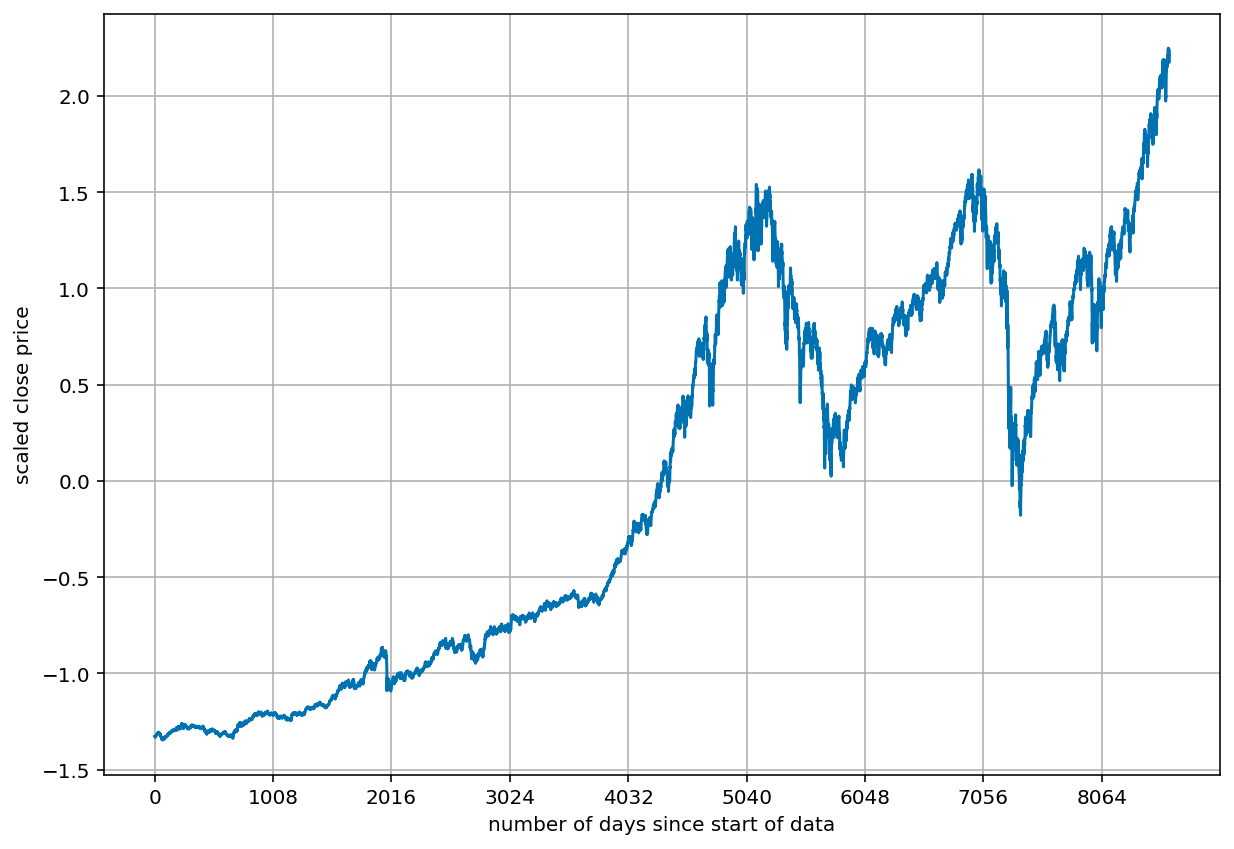

In [207]:
# Plot standard scaled close prices
plt.subplots(figsize = (10,7))
plt.plot(training_scaled[:,0])
plt.xlabel('number of days since start of data')
plt.ylabel('scaled close price')
plt.gca().xaxis.set_major_locator(MultipleLocator(1008))
plt.grid(True)
plt.show

# Prediction Modelling

In [208]:
# Create the training data
X_train, y_train = [], []

time_step = 50

length_train = 8639 # length data * 0.8

# This step is necessary to pass into a RNN
for i in range(time_step, length_train):
    X_train.append(training_scaled[i - time_step : i, :-1])
    y_train.append(training_scaled[i,-1])
    
X_train, y_train = np.array(X_train), np.array(y_train)

# Creating the test data
X_test, y_test = [], []

length_train = test_data.shape[0]

for i in range(time_step, length_train):
    X_test.append(testing_scaled[i - time_step : i, :-1])
    y_test.append(testing_scaled[i,-1])

X_test, y_test = np.array(X_test), np.array(y_test)

y_train = np.reshape(y_train, (y_train.shape[0],1))
y_test = np.reshape(y_test, (-1,1))

print(X_train.shape)
print(y_train.shape)

(8589, 50, 11)
(8589, 1)


In [213]:
# For now we are specifying the activation function to be relu, soon we will change it to test performance
model = Sequential([
    LSTM(64, activation = 'relu', return_sequences = True, input_dim = 11),
    LSTM(64, activation = 'relu', return_sequences = True),
    LSTM(64, activation = 'relu'),
    Dense(1, activation = 'linear')
])

In [217]:
learning_rate = 0.0005
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['mean_absolute_error'])

In [218]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, None, 64)          19456     
                                                                 
 lstm_31 (LSTM)              (None, None, 64)          33024     
                                                                 
 lstm_32 (LSTM)              (None, 64)                33024     
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 85,569
Trainable params: 85,569
Non-trainable params: 0
_________________________________________________________________


In [219]:
history = model.fit(X_train, y_train, epochs = 70, batch_size = 32)

Epoch 1/70
269/269 [==============================] - 11s 31ms/step - loss: 15.1671 - mean_absolute_error: 1.3115
Epoch 2/70
269/269 [==============================] - 9s 33ms/step - loss: 0.5138 - mean_absolute_error: 0.3991
Epoch 3/70
269/269 [==============================] - 9s 33ms/step - loss: 0.1755 - mean_absolute_error: 0.2367
Epoch 4/70
269/269 [==============================] - 9s 33ms/step - loss: 0.0980 - mean_absolute_error: 0.1784
Epoch 5/70
269/269 [==============================] - 9s 33ms/step - loss: 0.0716 - mean_absolute_error: 0.1582
Epoch 6/70
269/269 [==============================] - 9s 32ms/step - loss: 0.0507 - mean_absolute_error: 0.1364
Epoch 7/70
269/269 [==============================] - 9s 33ms/step - loss: 0.0442 - mean_absolute_error: 0.1284
Epoch 8/70
269/269 [==============================] - 9s 33ms/step - loss: 0.0421 - mean_absolute_error: 0.1238
Epoch 9/70
269/269 [==============================] - 9s 34ms/step - loss: 0.0369 - mean_absolute_erro

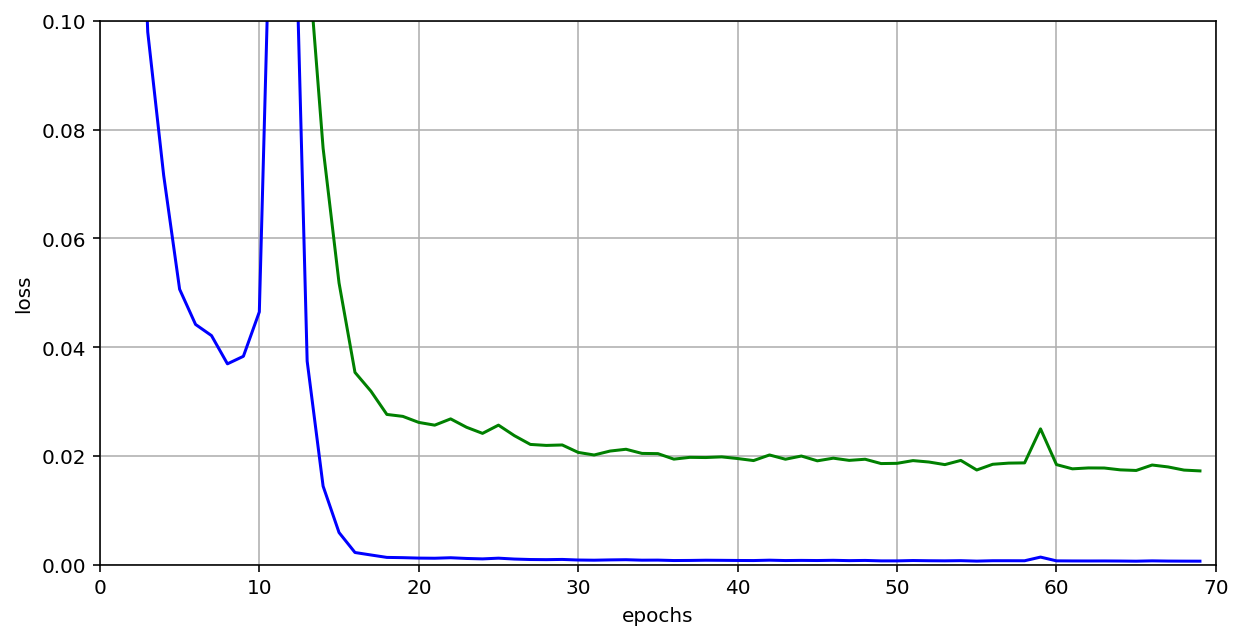

In [222]:
plt.figure(figsize = (10,5))
plt.plot(history.history["loss"], c = 'b')
plt.plot(history.history['mean_absolute_error'], c = 'g')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0,0.1)
plt.xlim(0,70)
plt.grid(True)
plt.show()

In [223]:
loss, accuracy = model.evaluate(X_test, y_test)

print('Test set loss:', loss)
print('Test set accuracy:', accuracy)

66/66 [==============================] - 1s 11ms/step - loss: 0.0061 - mean_absolute_error: 0.0538
Test set loss: 0.0060606664046645164
Test set accuracy: 0.05378784239292145


In [226]:
# Prediction on the training set
y_pred = model.predict(X_train)

# Unscale the predicted values

# create empty table with 13 fields (same number of columns)
y_pred_dataset_like = np.zeros(shape=(len(y_pred), 12))

# put the predicted values in the right field
y_pred_dataset_like[:,0] = y_pred[:,0]
# inverse transform and then select the right field
y_pred = scaler.inverse_transform(y_pred_dataset_like)[:,0]

y_pred = np.reshape(y_pred, (y_pred.shape[0],1))

print(y_pred.shape)

269/269 [==============================] - 3s 11ms/step
(8589, 1)


In [227]:
# Unscaled the training set values
# create empty table with 13 fields
y_train_dataset_like = np.zeros(shape=(len(y_train), 12))

# put the predicted values in the right field
y_train_dataset_like[:,0] = y_train[:,0]
# inverse transform and then select the right field
y_train = scaler.inverse_transform(y_train_dataset_like)[:,0]

y_train = np.reshape(y_train, (y_train.shape[0],1))

print(y_train.shape)

(8589, 1)


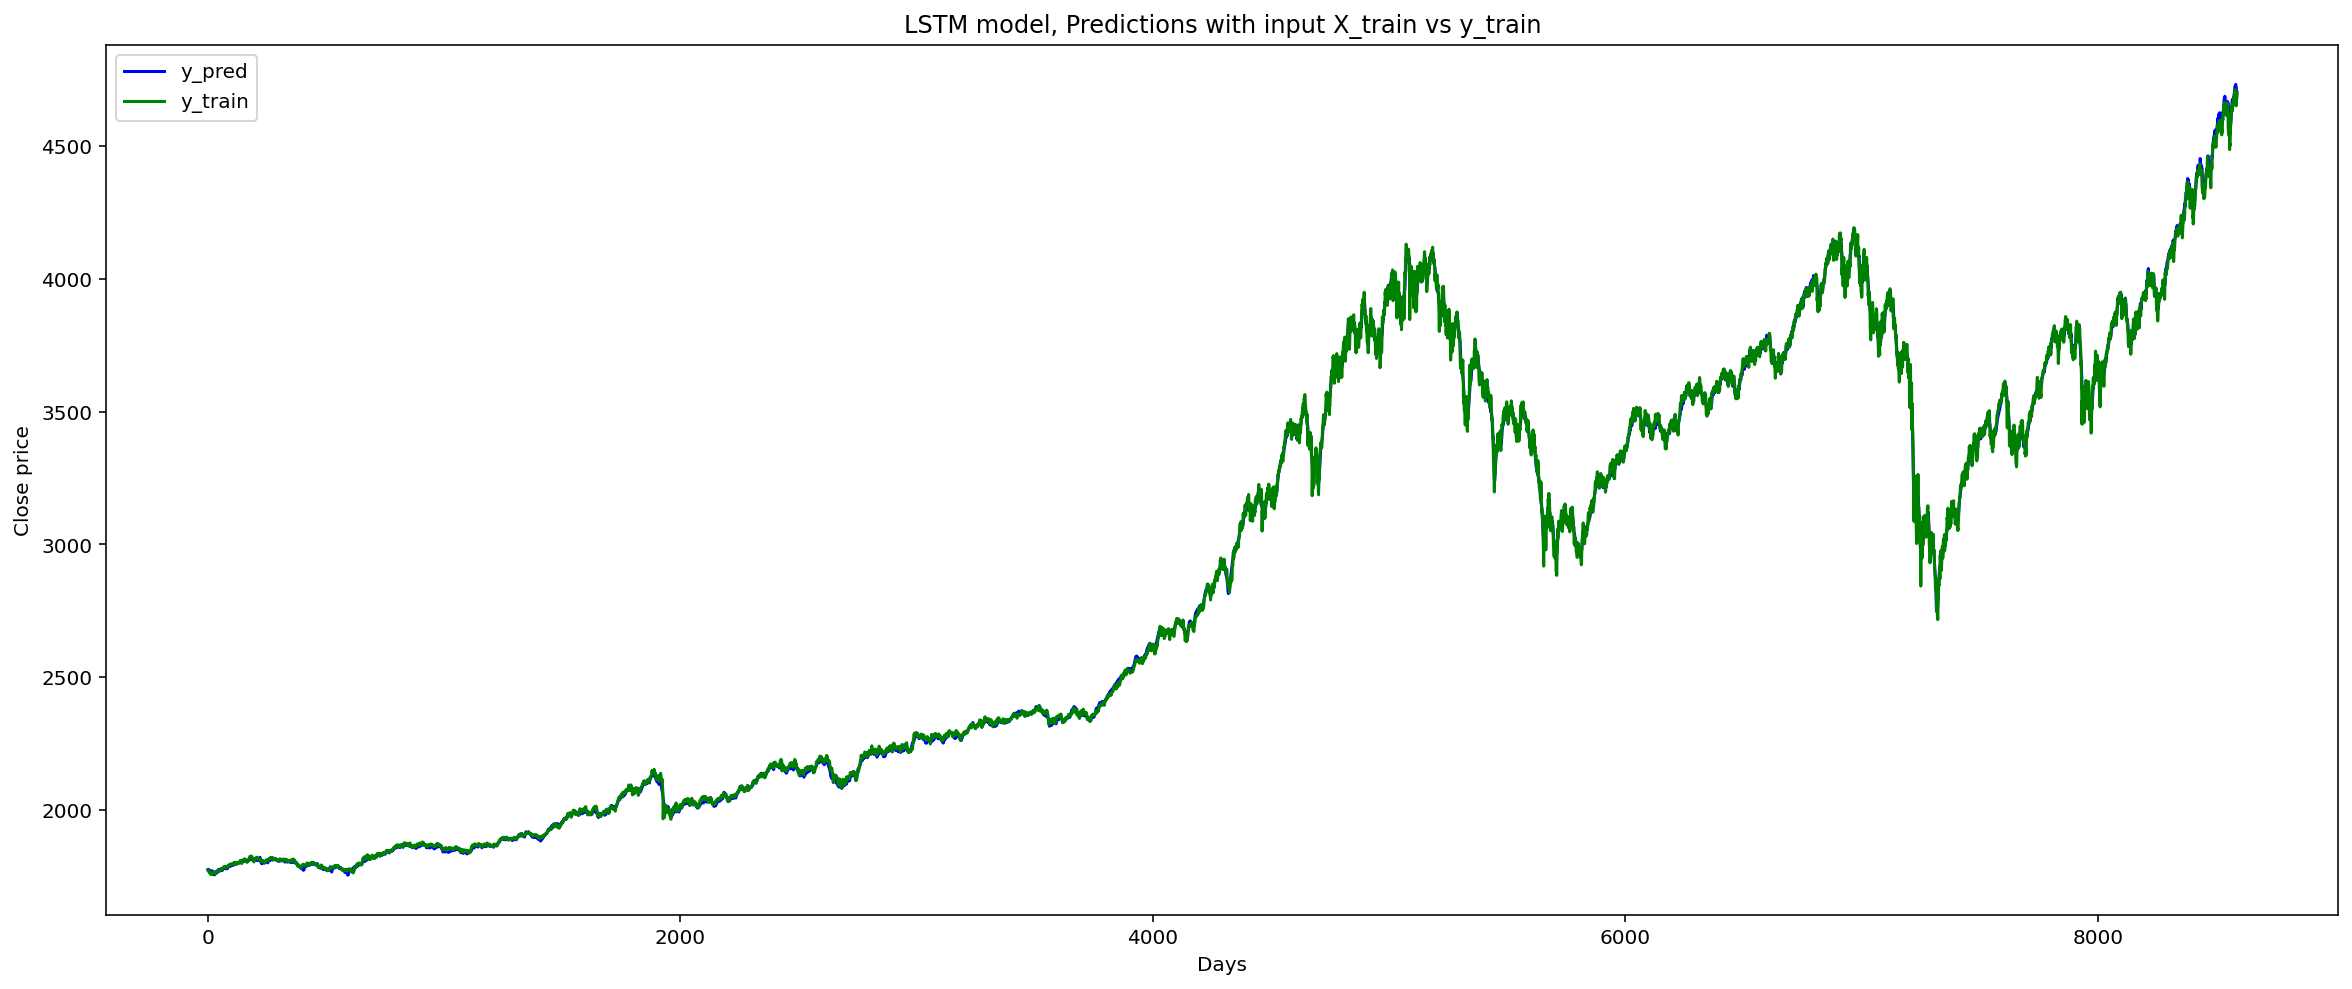

In [228]:
plt.figure(figsize = (20,8))
plt.plot(y_pred, color = "b", label = "y_pred" )
plt.plot(y_train, color = "g", label = "y_train")
plt.xlabel("Days")
plt.ylabel("Close price")
plt.title("LSTM model, Predictions with input X_train vs y_train")
plt.legend()
plt.show()

In [229]:
# Make a prediction on the test set
y_pred_on_test = model.predict(X_test)
y_pred_on_test = np.reshape(y_pred_on_test,(-1,1))

66/66 [==============================] - 1s 15ms/step


In [230]:
# Unscale these values
# create empty table with 13 fields
y_test_pred_dataset_like = np.zeros(shape=(len(y_pred_on_test), 12))

# put the predicted values in the right field
y_test_pred_dataset_like[:,0] = y_pred_on_test[:,0]
# inverse transform and then select the right field
y_pred_on_test = scaler.inverse_transform(y_test_pred_dataset_like)[:,0]

y_pred_on_test = np.reshape(y_pred_on_test,(-1,1))

print(y_pred_on_test.shape)

(2111, 1)


In [231]:
# create empty table with 13 fields
y_test_dataset_like = np.zeros(shape=(len(y_test), 12))

# put the predicted values in the right field
y_test_dataset_like[:,0] = y_test[:,0]
# inverse transform and then select the right field
y_test = scaler.inverse_transform(y_test_dataset_like)[:,0]

y_test = np.reshape(y_test, (-1,1))

print(y_test.shape)

(2111, 1)


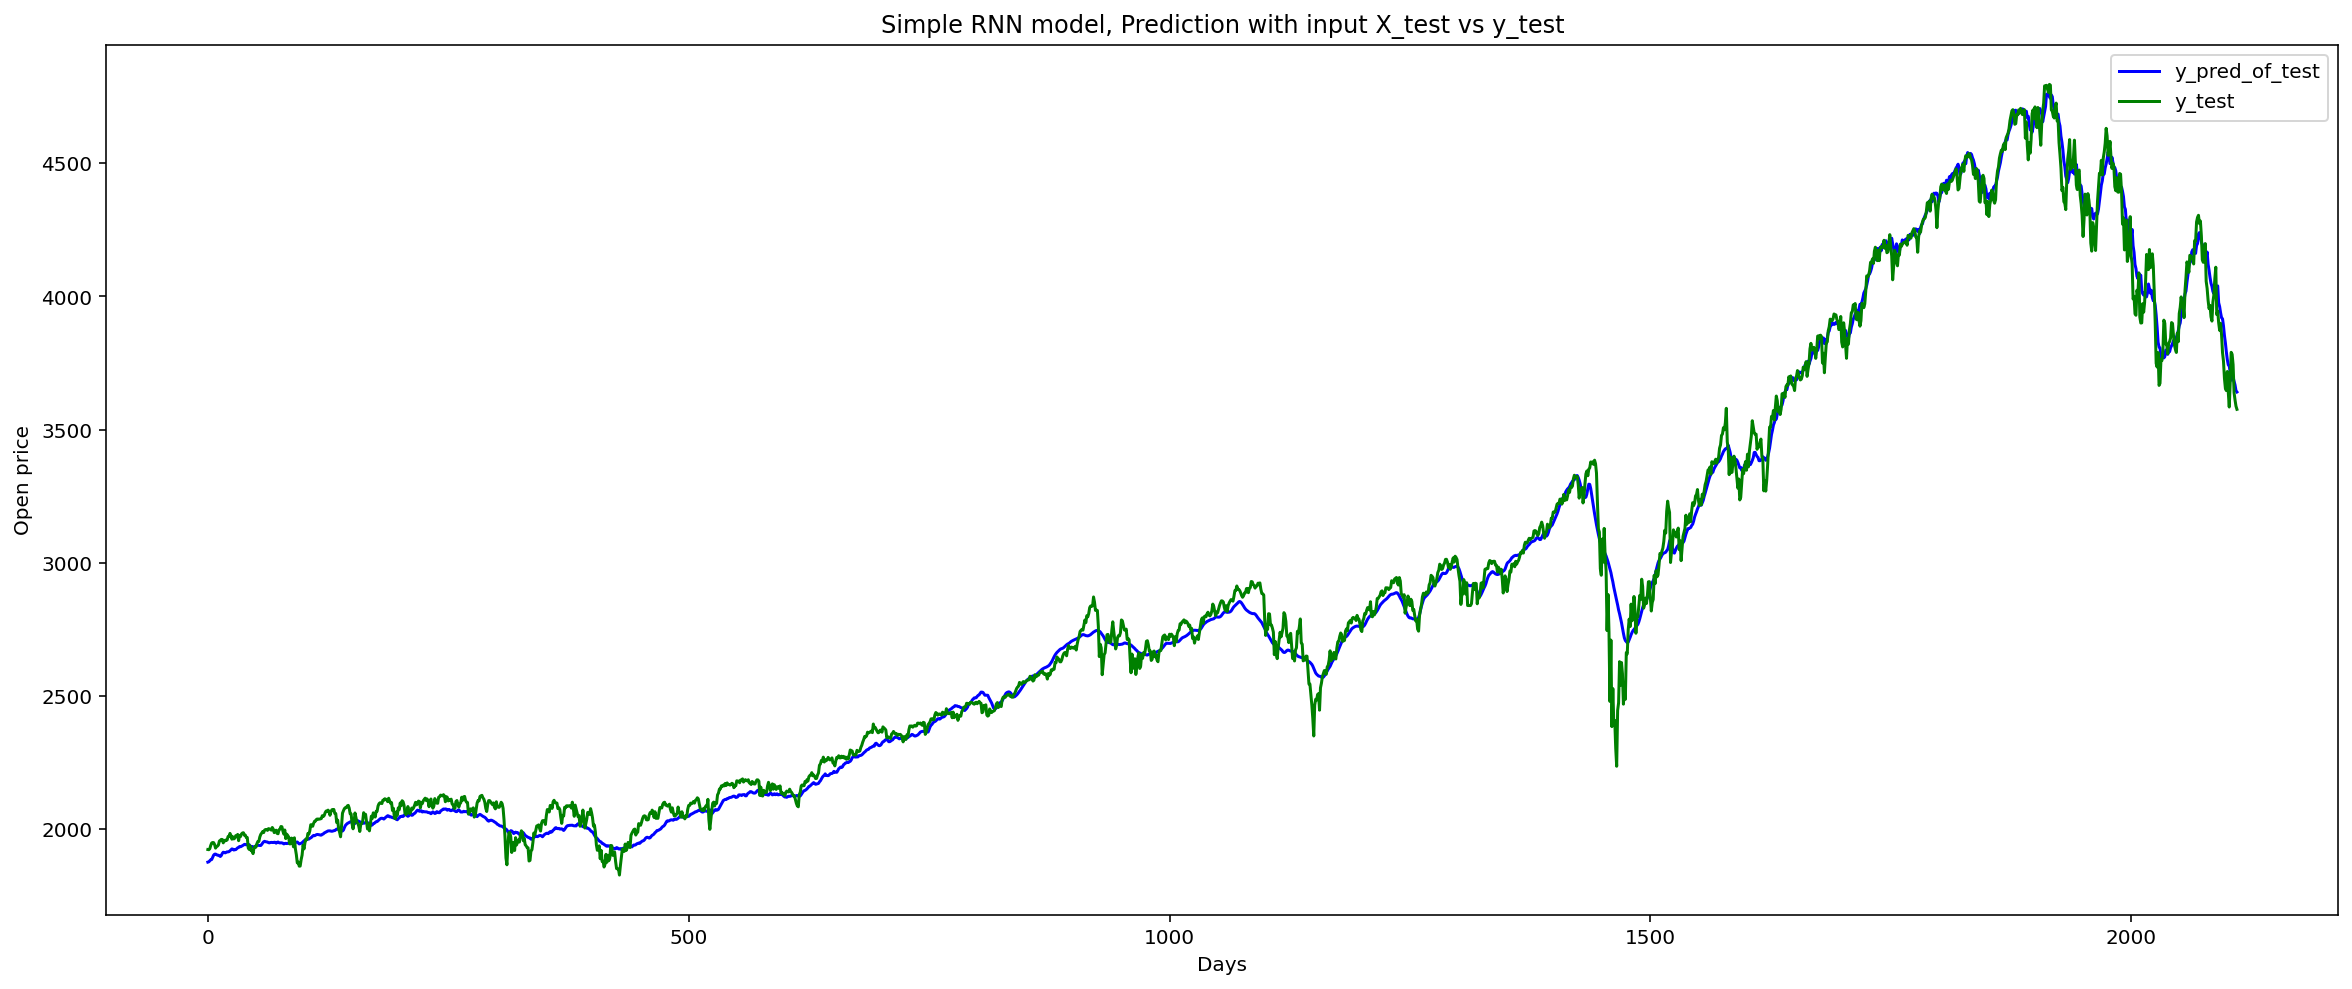

In [232]:
plt.figure(figsize = (20,8))
plt.plot(y_pred_on_test, label = "y_pred_of_test", c = "blue")
plt.plot(y_test, label = "y_test", c = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Prediction with input X_test vs y_test")
plt.legend()
plt.show()

In [146]:
y_test.shape[0]/5

422.2

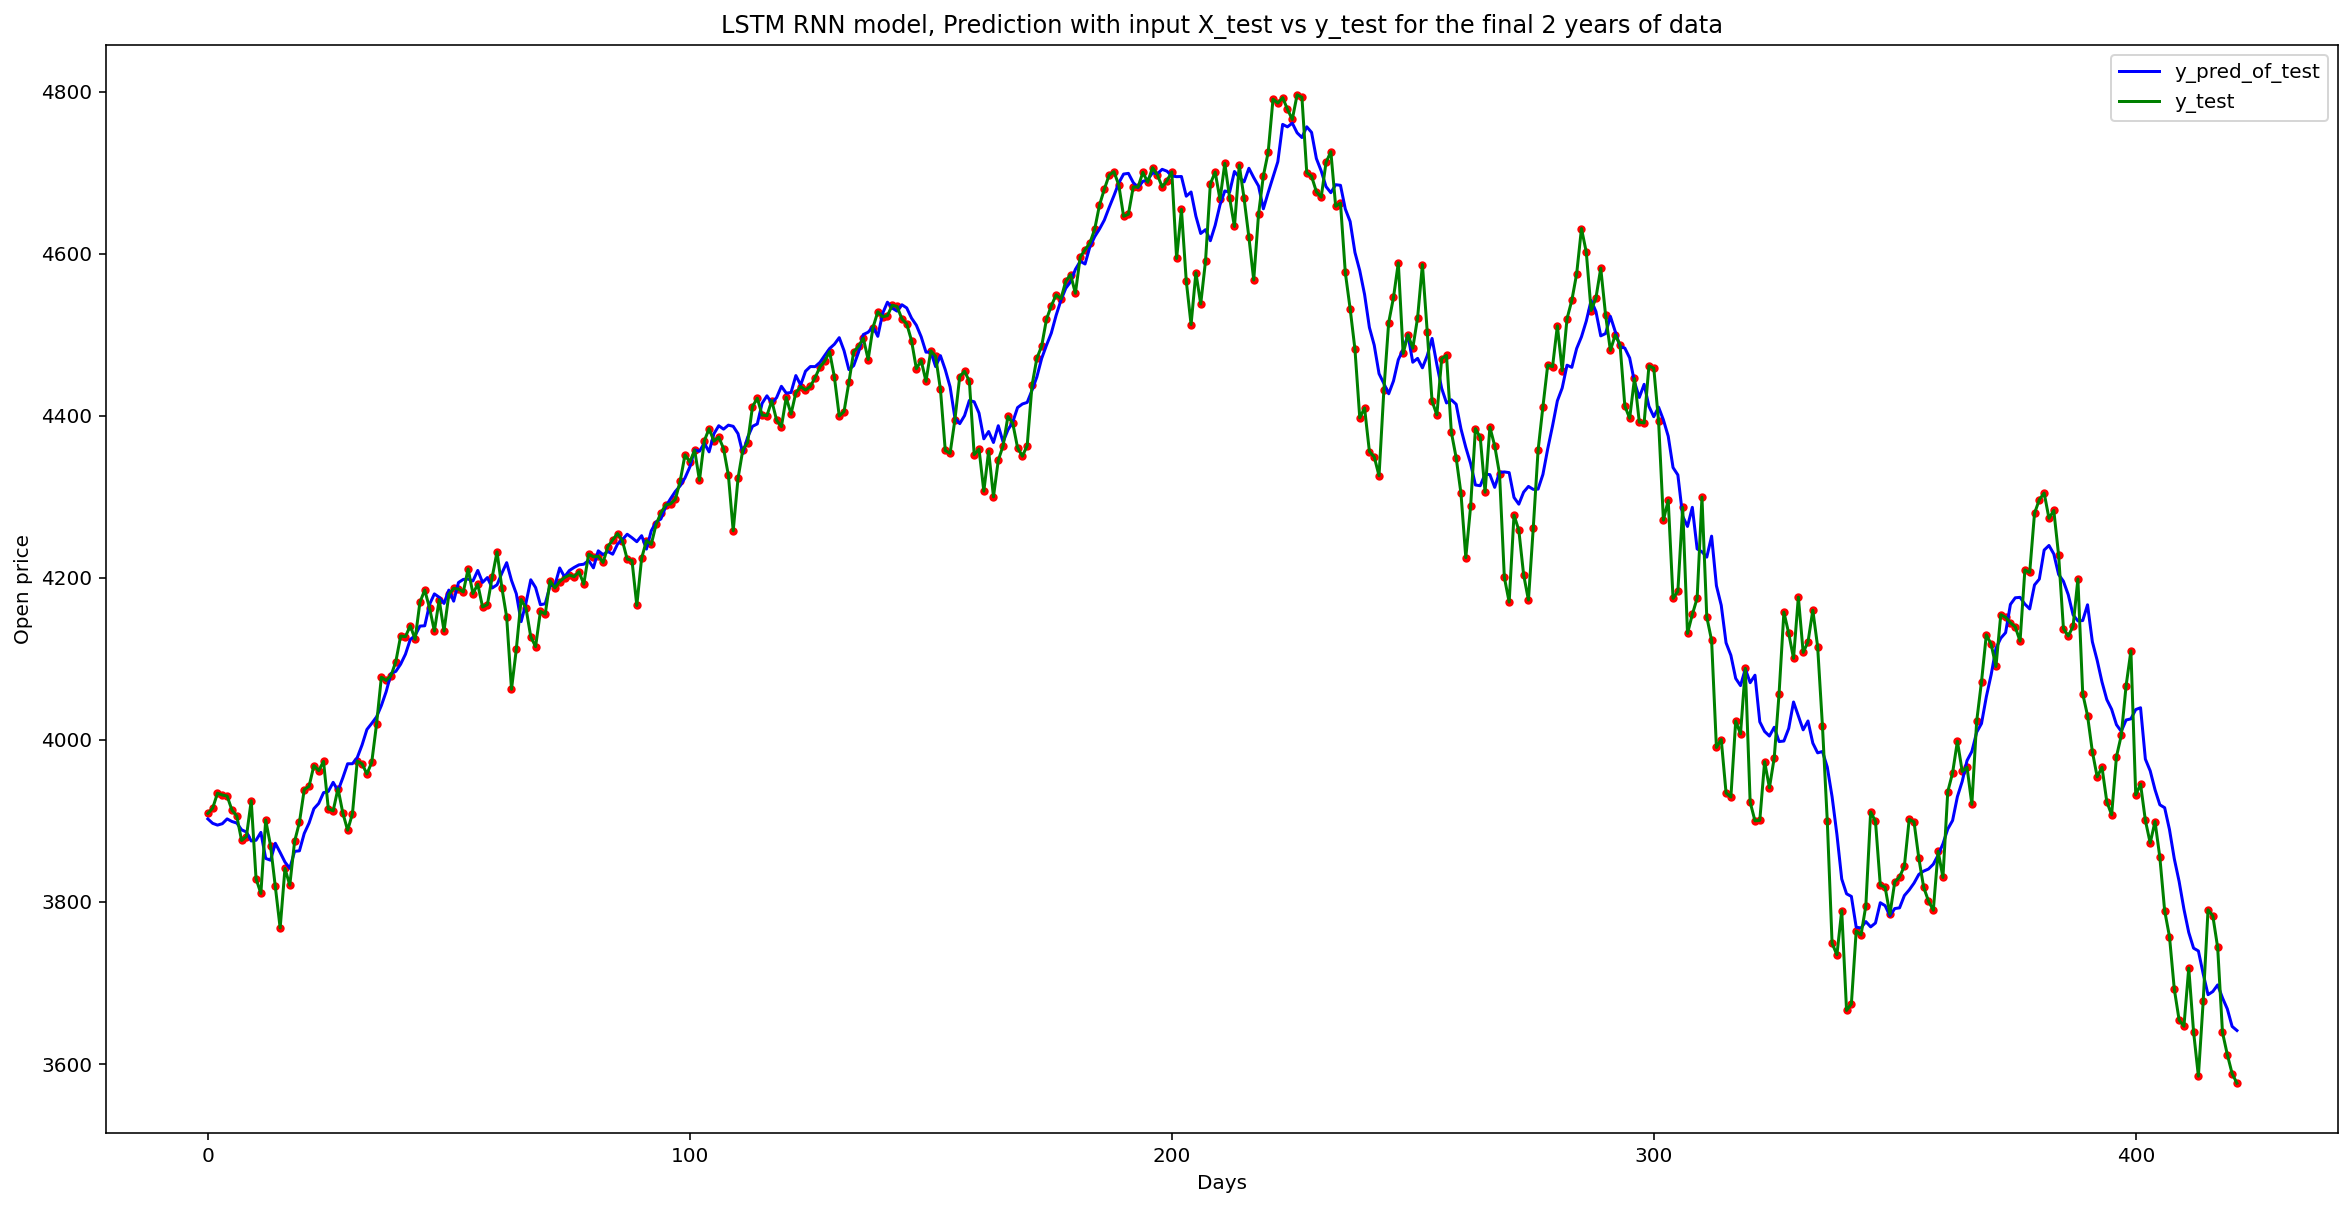

In [233]:
plt.figure(figsize = (20,10))
plt.plot(y_pred_on_test[(2111-422):], label = "y_pred_of_test", c = "blue")
plt.plot(y_test[(2111-422):], label = "y_test", c = "g")

x = np.arange(0,422,1)
plt.scatter(x, y_test[(2111 - 422):], s = 10, c = 'red')

plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("LSTM RNN model, Prediction with input X_test vs y_test for the final 2 years of data")
plt.legend()
plt.show()

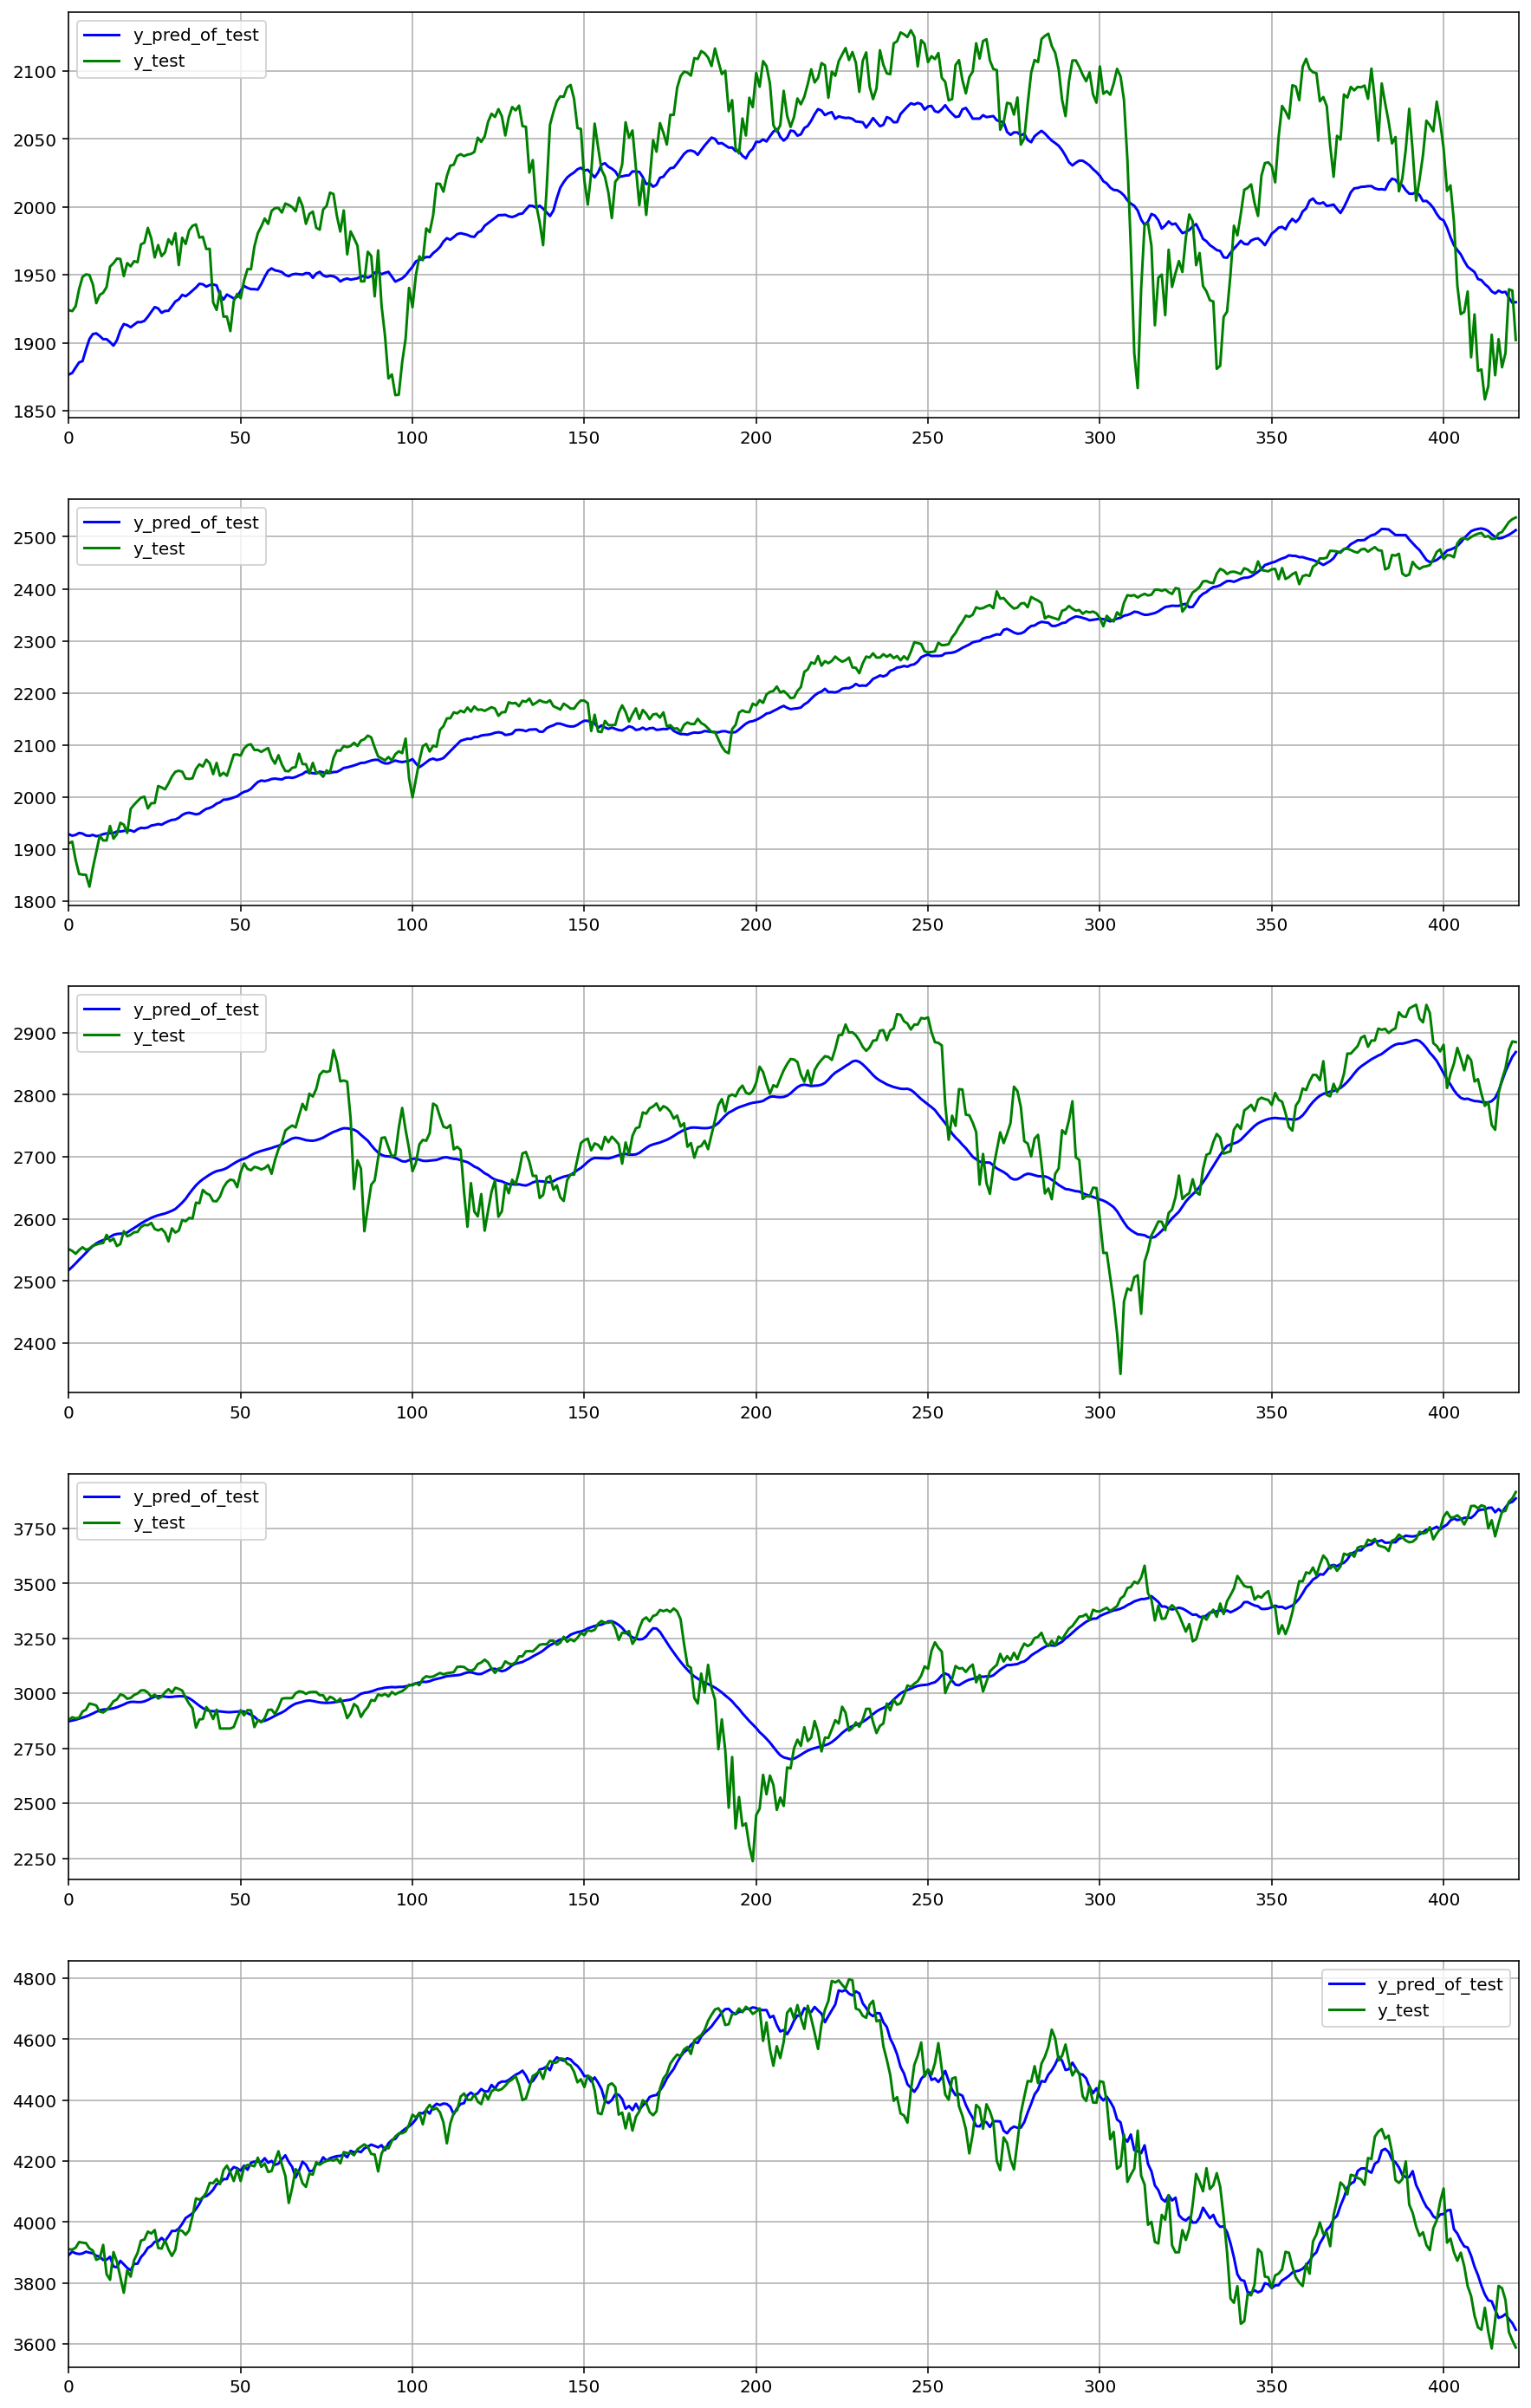

In [234]:
# Create 1 subplot for every "2" years
fig, ax = plt.subplots(5, figsize = (15,25))

for i in range(5):
    ax[i].plot(y_pred_on_test[i * 422: (i + 1) * 422], label = "y_pred_of_test", c = "blue")
    ax[i].plot(y_test[i * 422: (i + 1) * 422], label = "y_test", c = "g")
    ax[i].grid(True)
    ax[i].set_xlim([0,422])
    ax[i].legend()


# Testing strategy

In [269]:
class Testing:
    def __init__(self, predicted, data):
        # df_predicted = pd.DataFrame(y_pred_on_test, columns = ['Predicted Close'])
        # df_actual = pd.DataFrame(y_test, columns = ['Actual Close'])
        # df_from_pred = df[['open']][8689:]
        self.predicted = predicted
        self.actual = data[['close', 'open']]
        self.open_data = data['open']
        self.store = None
        
    def merge(self):
        # This function creates a new dataframe which merges existed columns
        self.actual = self.actual.reset_index(drop = True)
        self.predicted = self.predicted.shift(-1)
        self.predicted = self.predicted.dropna()
        self.store = pd.merge(self.actual, self.predicted, left_index = True, right_index = True)
        
        return self.store
        
    
    def set_signal(self):
        self.store['signal'] = None
        self.store['signal'] = np.where(
            self.store['Predicted Close'] - self.store['close'] >= 0, 1, -1
        )
        
        self.store['strat returns'] = None
        
        # Set mask that is true when signal col is positive
        mask = self.store['signal'] > 0
        self.store.loc[mask, 'strat returns'] = self.store.loc[mask, 'close'] - self.store.loc[mask, 'open']
        self.store.loc[self.store['signal'] < 0, 'strat returns'] = 0
        self.store['strat relative change'] = (self.store['strat returns'] / self.store['close'])
        self.store['return'] = self.store['close'] - self.store['close'].shift(1)
        self.store['buy hold relative change'] = (self.store['return'] / self.store['close'].shift(1))
        self.store['return'].loc[0] = 0
        self.store = self.store.dropna()
        
        return self.store
    
    def view_results(self):
        plt.figure(figsize = (15, 7))
        plt.plot(self.store['strat relative change'].cumsum(), label = 'strategy', c = "blue")
        plt.plot(self.store['buy hold relative change'].cumsum(), label = "buy and hold", c = "g")
        plt.xlabel("Days")
        plt.ylabel("returns")
        plt.title("LSTM RNN model, Prediction with input X_test vs y_test")
        plt.legend(loc = 'upper left')
        plt.grid(True)
        plt.xlim([0,2200])
        plt.show()

In [270]:
predicted = pd.DataFrame(y_pred_on_test, columns = ['Predicted Close'])
data = test_data

df2 = Testing(predicted = predicted, data = data)
df_actual = df2.merge()
# df_store.head()

In [271]:
df_actual.head()

,close,open,Predicted Close
0,1860.77,1872.25,1877.815119
1,1872.01,1860.09,1881.785223
2,1866.52,1874.53,1885.592384
3,1857.44,1867.67,1886.500299
4,1865.62,1859.48,1895.035877


In [272]:
df2.set_signal()

/var/folders/yg/069hjm3s3h93pz6xvwym8qxr0000gn/T/ipykernel_21513/4250802382.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.store['return'].loc[0] = 0


,close,open,Predicted Close,signal,strat returns,strat relative change,return,buy hold relative change
1,1872.01,1860.09,1881.785223,1,11.92,0.006367,11.24,0.006041
2,1866.52,1874.53,1885.592384,1,-8.01,-0.004291,-5.49,-0.002933
3,1857.44,1867.67,1886.500299,1,-10.23,-0.005508,-9.08,-0.004865
4,1865.62,1859.48,1895.035877,1,6.14,0.003291,8.18,0.004404
5,1852.56,1867.09,1902.711413,1,-14.53,-0.007843,-13.06,-0.007000
...,...,...,...,...,...,...,...,...
2105,3966.84,3965.72,3697.659197,-1,0,0.0,5.21,0.001315
2106,3921.05,3953.22,3681.607054,-1,0,0.0,-45.79,-0.011543
2107,4023.61,3951.43,3668.033309,-1,0,0.0,102.56,0.026156
2108,4072.43,4026.13,3646.383338,-1,0,0.0,48.82,0.012133


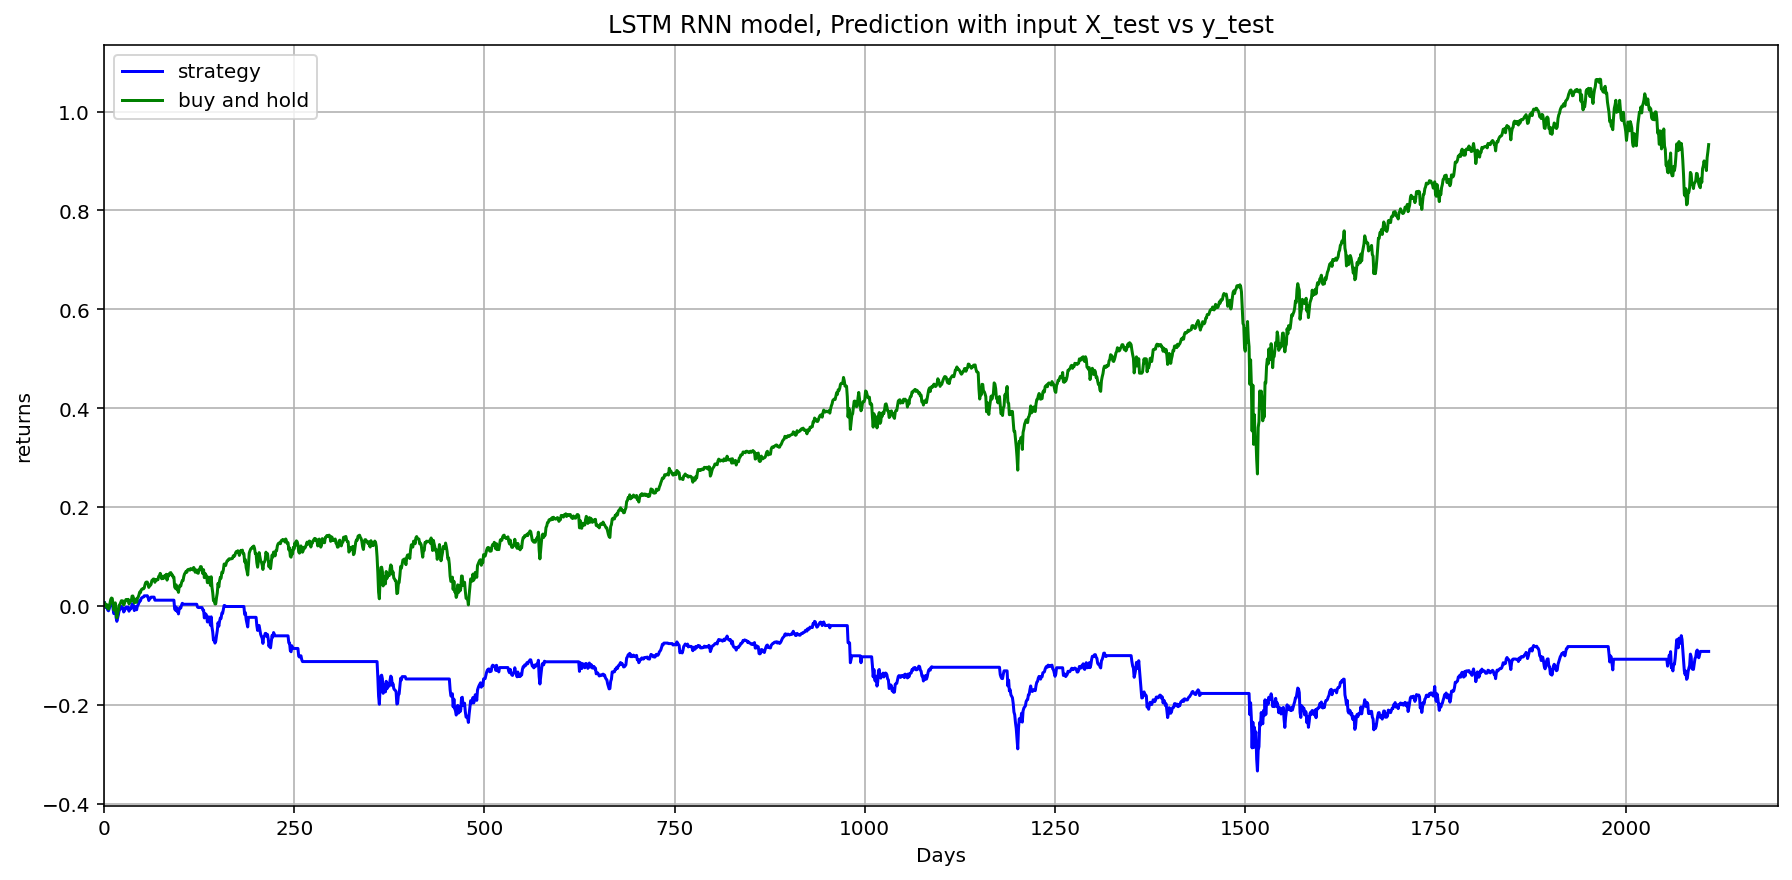

In [273]:
df2.view_results()

In [89]:
# Create DF to compare the actual prices and the predicted prices
df_predicted = pd.DataFrame(y_pred_on_test, columns = ['Predicted Close'])
df_actual = pd.DataFrame(y_test, columns = ['Actual Close'])

In [90]:
df_store = pd.DataFrame.join(df_actual, df_predicted, how = 'left')

In [91]:
df_from_pred = df[['open']][8689:]

df_from_pred = df_from_pred.reset_index()
# df_from_pred = df_from_pred.drop('Date', axis = 1)
df_from_pred.head()

,Date,open
0,2014-05-30,1923.87
1,2014-06-02,1923.07
2,2014-06-03,1923.06
3,2014-06-04,1928.52
4,2014-06-05,1942.41


In [92]:
df_from_pred = df_from_pred.drop('Date', axis=1)
df_store = pd.merge(df_store, df_from_pred, left_index = True, right_index = True)

In [93]:
df_store.head()

,Actual Close,Predicted Close,open
0,1924.015813,1908.478512,1923.87
1,1923.285689,1910.290025,1923.07
2,1926.926308,1911.335673,1923.06
3,1939.508451,1913.048302,1928.52
4,1948.489980,1915.409175,1942.41


In [94]:
# We shift down by one, as our "buy" signal is when the predicted close for the next day, is higher than the current
df_store['Predicted Close'] = df_store['Predicted Close'].shift(-1)
df_store.rename(columns = {'Predicted Close': 'Predicted Close d+1'}, inplace = True)
df_store = df_store.dropna()
df_store.head()

,Actual Close,Predicted Close d+1,open
0,1924.015813,1910.290025,1923.87
1,1923.285689,1911.335673,1923.07
2,1926.926308,1913.048302,1923.06
3,1939.508451,1915.409175,1928.52
4,1948.489980,1917.876094,1942.41


In [95]:
# Create an empty column to store the signal
df_store['signal'] = np.nan

# Sets the signal, if the prediction for the next day is greater than the current close, then assign 1.
for i in range(len(df_store)):
    if (df_store.iloc[i][1] - df_store.iloc[i][2]) >= 0:
        df_store['signal'].iloc[i] = 1
    else:
        df_store['signal'].iloc[i] = -1

In [96]:
# Create a copy table
df_results = df_store.copy()

#Create empty col

df_results['strat returns'] = np.nan
df_results['strat returns'].iloc[0] = 0

for i in range(1, len(df_store)-1):
    if df_results['signal'].iloc[i] > 0:
        # In this run through we will use the open value 
        df_results['strat returns'].iloc[i] = df_results['Actual Close'].iloc[i] - df_results['open'].iloc[i]
    elif df_results['signal'].iloc[i] < 0:
        df_results['strat returns'].iloc[i] = 0

In [97]:
df_results['return'] = df_results['Actual Close'] - df_results['Actual Close'].shift(1)

In [98]:
df_results

,Actual Close,Predicted Close d+1,open,signal,strat returns,return
0,1924.015813,1910.290025,1923.87,-1.0,0.000000,NaN
1,1923.285689,1911.335673,1923.07,-1.0,0.000000,-0.730124
2,1926.926308,1913.048302,1923.06,-1.0,0.000000,3.640620
3,1939.508451,1915.409175,1928.52,-1.0,0.000000,12.582142
4,1948.489980,1917.876094,1942.41,-1.0,0.000000,8.981529
...,...,...,...,...,...,...
2105,3782.642271,3767.321339,3753.25,1.0,29.392271,-7.651303
2106,3743.875670,3751.041261,3771.97,-1.0,0.000000,-38.766601
2107,3638.997813,3705.347780,3706.74,-1.0,0.000000,-104.877857
2108,3611.723169,3698.189231,3647.51,1.0,-35.786831,-27.274644


In [99]:
df_results['strat relative change'] = (df_results['strat returns'] / df_results['Actual Close'])
df_results['buy hold relative change'] = (df_results['return'] / df_results['Actual Close'].shift(1))

In [100]:
df_results['return'].iloc[0] = 0
df_results = df_results.dropna()

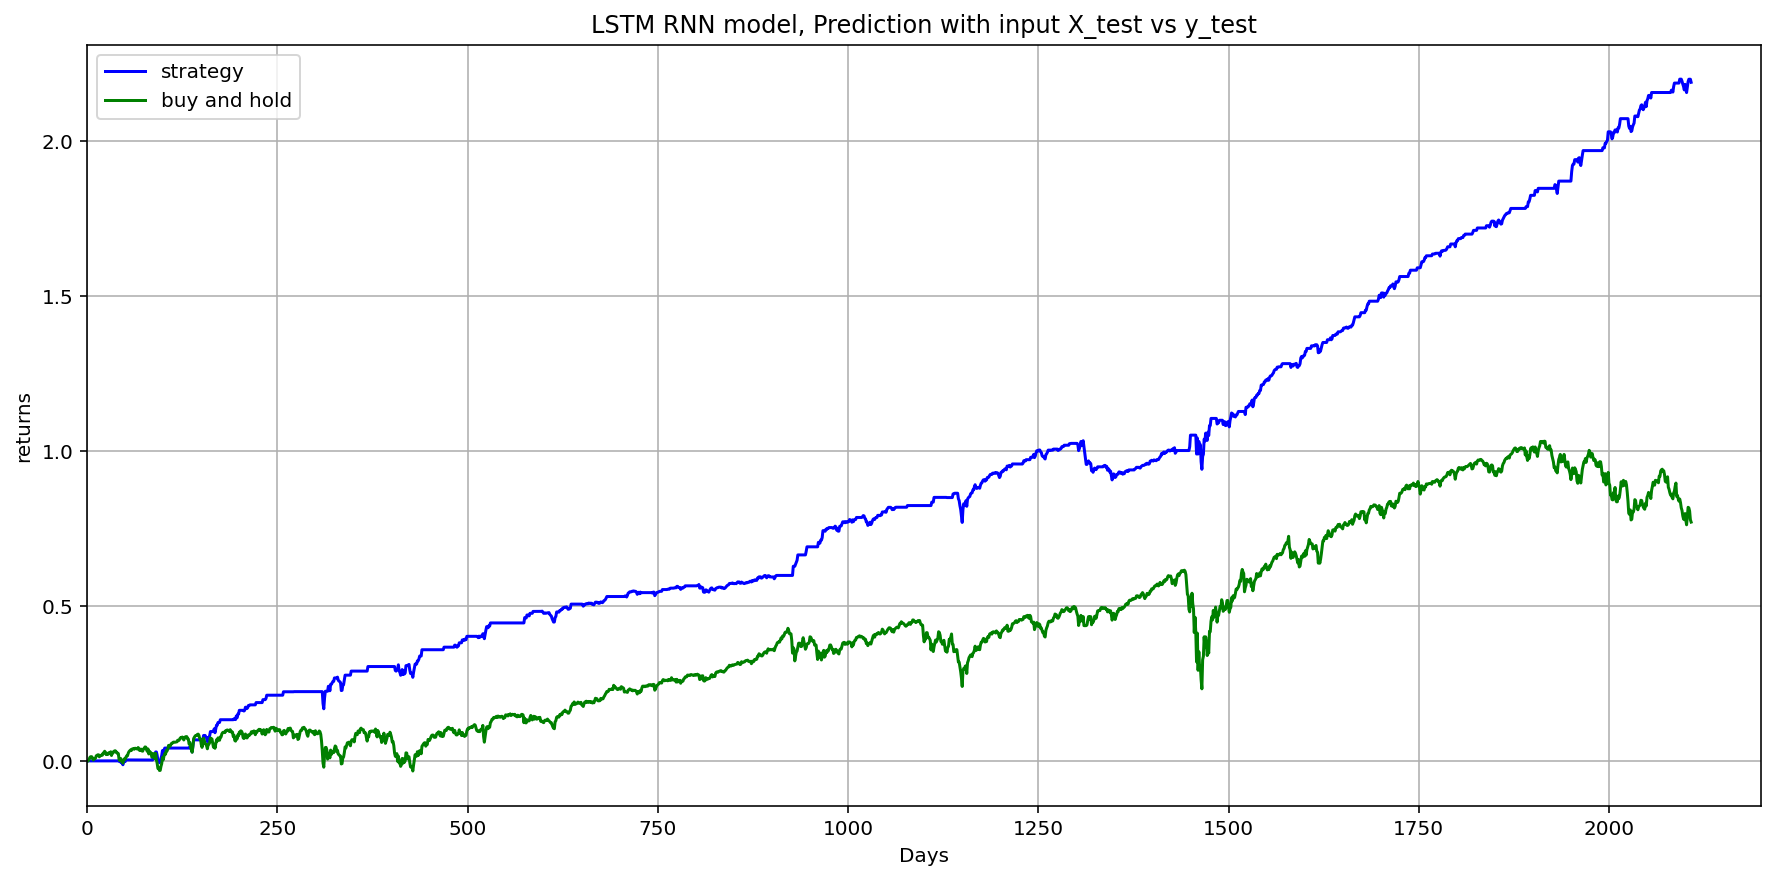

In [101]:
plt.figure(figsize = (15, 7))
plt.plot(df_results['strat relative change'].cumsum(), label = 'strategy', c = "blue")
plt.plot(df_results['buy hold relative change'].cumsum(), label = "buy and hold", c = "g")
plt.xlabel("Days")
plt.ylabel("returns")
plt.title("LSTM RNN model, Prediction with input X_test vs y_test")
plt.legend(loc = 'upper left')
plt.grid(True)
plt.xlim([0,2200])
plt.show()

In [102]:
print('10 year return applying strategy:', 1 + df_results['strat relative change'].sum())
print('10 year return buy and hold:', 1 + df_results['buy hold relative change'].sum())

10 year return applying strategy: 3.188380856278177
10 year return buy and hold: 1.7700659869843665


In [103]:
# Invest 100,000 ~ 10 years ago
print(100000 * (1 + df_results['strat relative change'].sum()))
print(100000 * (1 + df_results['buy hold relative change'].sum()))

318838.08562781767
177006.59869843663


In [104]:
df_results['strat relative change'].sum() / df_results['buy hold relative change'].sum()

2.8418095244643027

In [105]:
df_results.head()

,Actual Close,Predicted Close d+1,open,signal,strat returns,return,strat relative change,buy hold relative change
1,1923.285689,1911.335673,1923.07,-1.0,0.0,-0.730124,0.0,-0.000379
2,1926.926308,1913.048302,1923.06,-1.0,0.0,3.640620,0.0,0.001893
3,1939.508451,1915.409175,1928.52,-1.0,0.0,12.582142,0.0,0.006530
4,1948.489980,1917.876094,1942.41,-1.0,0.0,8.981529,0.0,0.004631
5,1950.320292,1919.247237,1948.97,-1.0,0.0,1.830312,0.0,0.000939


In [106]:
initial_investment = 1000

df_results['investments'] = None
df_results['investments'].iloc[0] = initial_investment

df_results.head()

/var/folders/yg/069hjm3s3h93pz6xvwym8qxr0000gn/T/ipykernel_21513/2918116008.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['investments'] = None
/var/folders/yg/069hjm3s3h93pz6xvwym8qxr0000gn/T/ipykernel_21513/2918116008.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['investments'].iloc[0] = initial_investment


,Actual Close,Predicted Close d+1,open,signal,strat returns,return,strat relative change,buy hold relative change,investments
1,1923.285689,1911.335673,1923.07,-1.0,0.0,-0.730124,0.0,-0.000379,1000
2,1926.926308,1913.048302,1923.06,-1.0,0.0,3.640620,0.0,0.001893,None
3,1939.508451,1915.409175,1928.52,-1.0,0.0,12.582142,0.0,0.006530,None
4,1948.489980,1917.876094,1942.41,-1.0,0.0,8.981529,0.0,0.004631,None
5,1950.320292,1919.247237,1948.97,-1.0,0.0,1.830312,0.0,0.000939,None


In [107]:
df_results.shape

(2108, 9)

In [108]:
for i in range(df_results.shape[0]-1):
    df_results['investments'].iloc[i+1] = df_results['investments'].iloc[i] * (df_results['strat relative change'].iloc[i] + 1)

/var/folders/yg/069hjm3s3h93pz6xvwym8qxr0000gn/T/ipykernel_21513/992036920.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['investments'].iloc[i+1] = df_results['investments'].iloc[i] * (df_results['strat relative change'].iloc[i] + 1)


In [112]:
print('Value of a 10,000 investment from 10 years ago: ' + '%.2f' % df_results['investments'].iloc[df_results.shape[0]-1])

Value of a 10,000 investment from 10 years ago: 8620.50


In [110]:
df_results['investments'].iloc[df_results.shape[0]-1] / 100000

0.08620504277162916

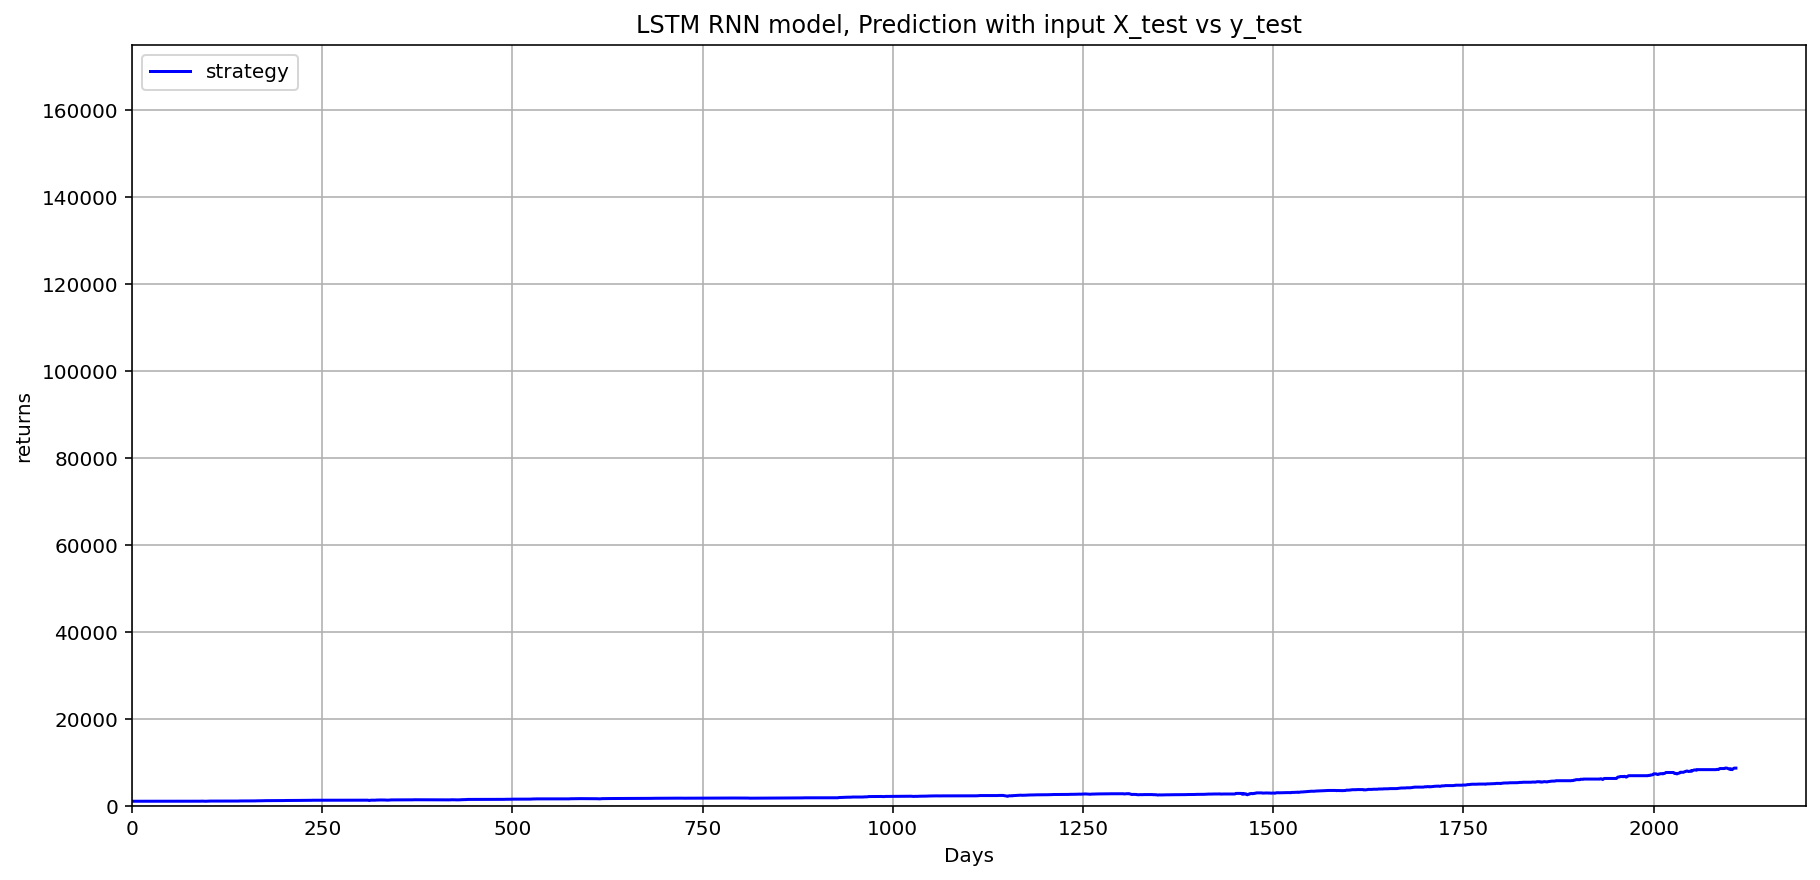

In [111]:
plt.figure(figsize = (15, 7))
plt.plot(df_results['investments'], label = 'strategy', c = "blue")
plt.xlabel("Days")
plt.ylabel("returns")
plt.title("LSTM RNN model, Prediction with input X_test vs y_test")
plt.legend(loc = 'upper left')
plt.grid(True)
plt.xlim([0,2200])
plt.ylim(0,175000)
plt.show()

# Let's retrain the model, but changing some of the parameters

We will retain relu, but change the initialiser.

By default LSTM uses glorot uniform

In [165]:
df = clean_data()

# Split data into training and test sets, we will do the same but with validation later
training_data = df[:8639]
test_data = df[8639:]

training_scaled = scaler.fit_transform(training_data)
testing_scaled = scaler.fit_transform(test_data)

# Create the training data
X_train, y_train = [], []

time_step = 50

length_train = 8639 # length data * 0.8

# This step is necessary to pass into a RNN
for i in range(time_step, length_train):
    X_train.append(training_scaled[i - time_step : i, :-1])
    y_train.append(training_scaled[i,-1])
    
X_train, y_train = np.array(X_train), np.array(y_train)

# Creating the test data
X_test, y_test = [], []

length_train = test_data.shape[0]

for i in range(time_step, length_train):
    X_test.append(testing_scaled[i - time_step : i, :])
    y_test.append(testing_scaled[i,0])

X_test, y_test = np.array(X_test), np.array(y_test)

y_train = np.reshape(y_train, (y_train.shape[0],1))
y_test = np.reshape(y_test, (-1,1))

print(X_train.shape)
print(y_train.shape)

(8589, 50, 13)
(8589, 1)


<function matplotlib.pyplot.show(close=None, block=None)>

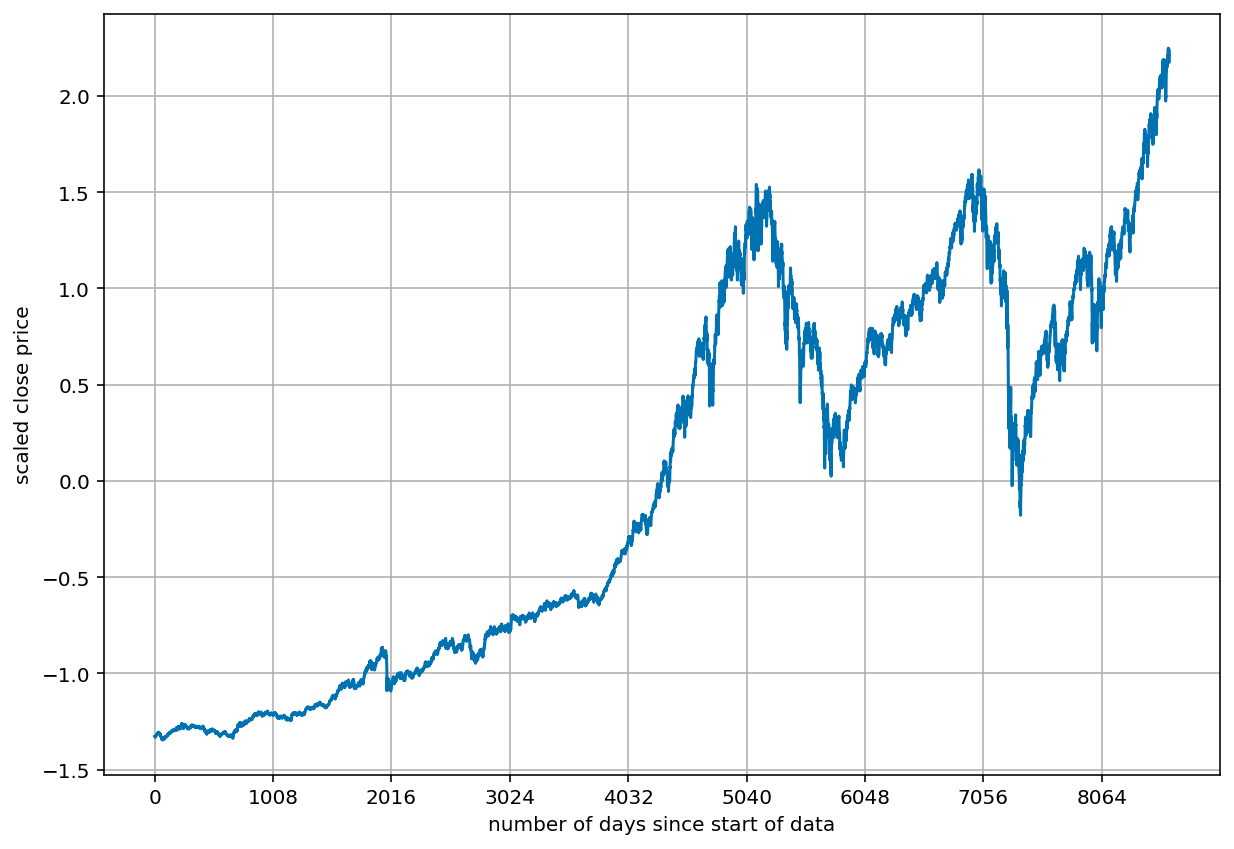

In [170]:
# Plot standard scaled close prices
plt.subplots(figsize = (10,7))
plt.plot(training_scaled[:,0])
plt.xlabel('number of days since start of data')
plt.ylabel('scaled close price')
plt.gca().xaxis.set_major_locator(MultipleLocator(1008))
plt.grid(True)
plt.show

In [171]:
from tensorflow.keras.initializers import HeNormal

model = Sequential([
    LSTM(64, activation = 'relu', kernel_initializer = HeNormal(seed = 24), return_sequences = True, input_dim = 13),
    LSTM(64, activation = 'relu', kernel_initializer = HeNormal(seed = 24), return_sequences = True),
    LSTM(64, activation = 'relu', kernel_initializer = HeNormal(seed = 24)),
    Dense(1, activation = 'linear')
])

In [172]:
learning_rate = 0.005
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['mean_absolute_error'])

In [173]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, None, 64)          19968     
                                                                 
 lstm_25 (LSTM)              (None, None, 64)          33024     
                                                                 
 lstm_26 (LSTM)              (None, 64)                33024     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 86,081
Trainable params: 86,081
Non-trainable params: 0
_________________________________________________________________


In [174]:
history = model.fit(X_train, y_train, epochs = 70, batch_size = 32)

Epoch 1/70
269/269 [==============================] - 11s 31ms/step - loss: 32684483018752.0000 - mean_absolute_error: 254989.0312
Epoch 2/70
269/269 [==============================] - 9s 33ms/step - loss: 32802512.0000 - mean_absolute_error: 1691.3116
Epoch 3/70
269/269 [==============================] - 9s 33ms/step - loss: 838221.1875 - mean_absolute_error: 702.3517
Epoch 4/70
269/269 [==============================] - 9s 33ms/step - loss: 8548569.0000 - mean_absolute_error: 1028.9835
Epoch 5/70
 21/269 [=>............................] - ETA: 8s - loss: 217096.0469 - mean_absolute_error: 382.5245

KeyboardInterrupt: 